In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# challenge: https://github.com/raymondfdavey/ML-Challenge2023

# FULL DATASET INFO: https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/#files

## Methods

### Study participants

There were 32 healthy participants in the study - 13 men and 19 women - who were of ages ranging between 23 and 52 years. There were 31 right-handed participants; one individual identified themselves as ambidextrous.

### Devices setup and placement

Participants wore four 3-axial ActiGraph GT3X+ wearable accelerometer devices, placed at left ankle, right ankle, left hip, and left wrist, respectively. ActiLife software was used to synchronize the devices to the same external clock. In theory, the synchronization procedure should assure parallel measurement among devices; however, a subsecond-level desynchronization of the devices could have happened over time (see Sect 3.8 in Karas et al. 2019). No serious desynchronization has been observed in this data. For each device, the data collection frequency was set to 100 Hz (100 observations per second).

Each device was attached to a participant's body using velcro bands. The sensors at the ankles were placed on the outside side of the ankles. The sensor at the wrist was placed similarly to a regular watch placed on the top side of the wrist. The sensor at the left hip was attached to the belt of the participant on the left hip side; when a belt was not available, the device was either attached to the corresponding belt loop or clipped to the waistband.

### Walking and driving trials

The study protocol included a walking pathway (approx. 0.66 miles) followed by a driving trail (approx. 12.8 miles). Data were downloaded immediately following each participant’s session.

The walking component consisted of 5 periods of walking on level ground, 6 periods of descending stairs, and 6 periods of ascending the stairs; the part lasted between 9.0 and 13.5 minutes. Participants were asked to walk at their usual pace along a predefined course to imitate a free-living activity. One participant briefly forgot the instructions and had an additional period of walking on the level ground before turning around to ascend the stairs.

Right after the walking part of the experiment, participants were accompanied to their vehicle, and they then drove on a predefined route for between 18 and 30 min, depending on traffic. The route included both highway and city driving.

To ensure accuracy of identifying the start and stop times of different activities, participants were asked to clap three times at the beginning and end of each activity. The clapping movement generated three spikes of magnitude in the raw accelerometry data signal, allowing to mark the beginning and end of each activity and to accurately assign activity labels for each section of the protocol in a data preprocessing stage. Data corresponding to a few seconds before/after the first/last activity are included and labeled as "non-study activity".

### Data Description

This project includes raw accelerometry data files, a data files dictionary, and participant demographic information. All data are anonymized. Specifically, the project files include:

1. raw_accelerometry_data: a directory with 32 data files in CSV format. Each file corresponds to raw accelerometry data measurements of 1 study participant. File names follow the convention: "subj_id.csv". Each file contains 14 variables:

```
activity: Type of activity (1=walking; 2=descending stairs; 3=ascending stairs; 4=driving; 77=clapping; 99=non-study activity)
time_s: Time from device initiation (seconds [s])
lw_x: Left wrist x-axis measurement (gravitation acceleration [g])
lw_y: Left wrist y-axis measurement (gravitation acceleration [g])
lw_z: Left wrist z-axis measurement (gravitation acceleration [g])
lh_x: Left hip x-axis measurement (gravitation acceleration [g])
lh_y: Left hip y-axis measurement (gravitation acceleration [g])
lh_z: Left hip z-axis measurement (gravitation acceleration [g])
la_x: Left ankle x-axis measurement (gravitation acceleration [g])
la_y: Left ankle y-axis measurement (gravitation acceleration [g])
la_z: Left ankle z-axis measurement (gravitation acceleration [g])
ra_x: Right ankle x-axis measurement (gravitation acceleration [g])
ra_y: Right ankle y-axis measurement (gravitation acceleration [g])
ra_z: Right ankle z-axis measurement (gravitation acceleration [g])
```


In [2]:
import pandas as pd

df = pd.read_csv("movementSensorData.csv")
df = df.rename(columns={'Unnamed: 0': 'time_ms'})

print(df)

# df.plot(x=)

        time_ms  activity  time_s   lw_x   lw_y   lw_z
0         63804         2  638.05 -0.188 -0.941 -0.316
1         63805         2  638.06 -0.121 -0.879 -0.320
2         63806         2  638.07 -0.070 -0.852 -0.305
3         63807         2  638.08 -0.023 -0.879 -0.277
4         63808         2  638.09  0.008 -0.941 -0.242
...         ...       ...     ...    ...    ...    ...
507822    96386         1  963.87 -0.012  0.984 -0.363
507823    96387         1  963.88  0.016  0.938 -0.379
507824    96388         1  963.89  0.039  0.910 -0.391
507825    96389         1  963.90  0.066  0.898 -0.395
507826    96390         1  963.91  0.105  0.895 -0.398

[507827 rows x 6 columns]


<Axes: title={'center': 'XYZ OVER INDEX'}>

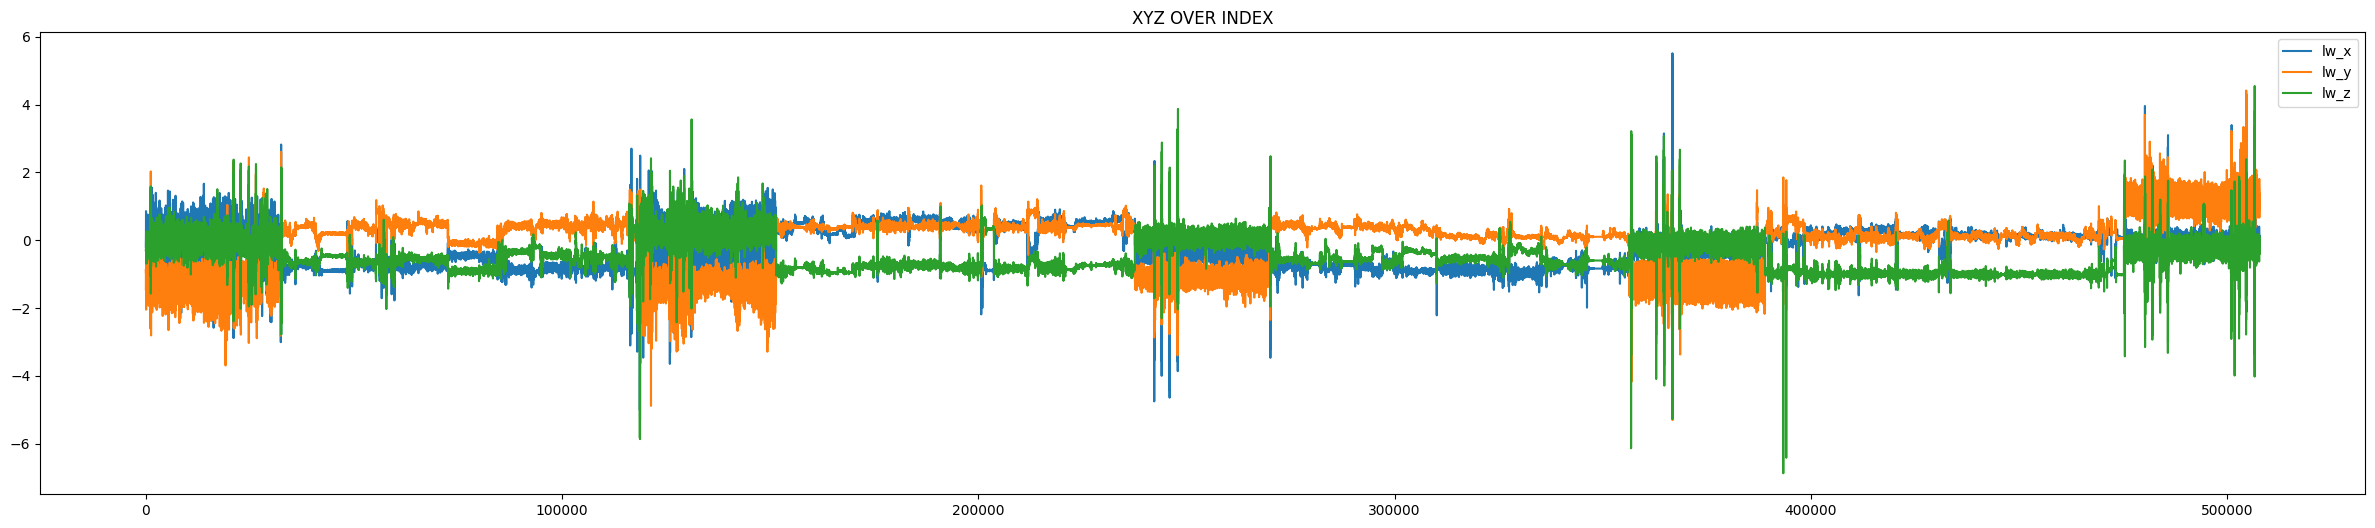

In [3]:
df.plot(y=["lw_x", "lw_y", "lw_z"], use_index=True,
        figsize=(30, 6), title="XYZ OVER INDEX")

In [4]:
df['time_diff'] = df['time_ms'].diff()

# Initialize the segment number
segment = 0
segments = []

# Iterate over the time_diff column to assign segment numbers
for diff in df['time_diff']:
    if diff > 1:
        segment += 1
    segments.append(segment)

# Add the segment numbers to the DataFrame
df['segment'] = segments

# Now df has an additional column 'segment' for segmenting the data

In [5]:
df['segment'].unique()

array([0, 1, 2, 3, 4])

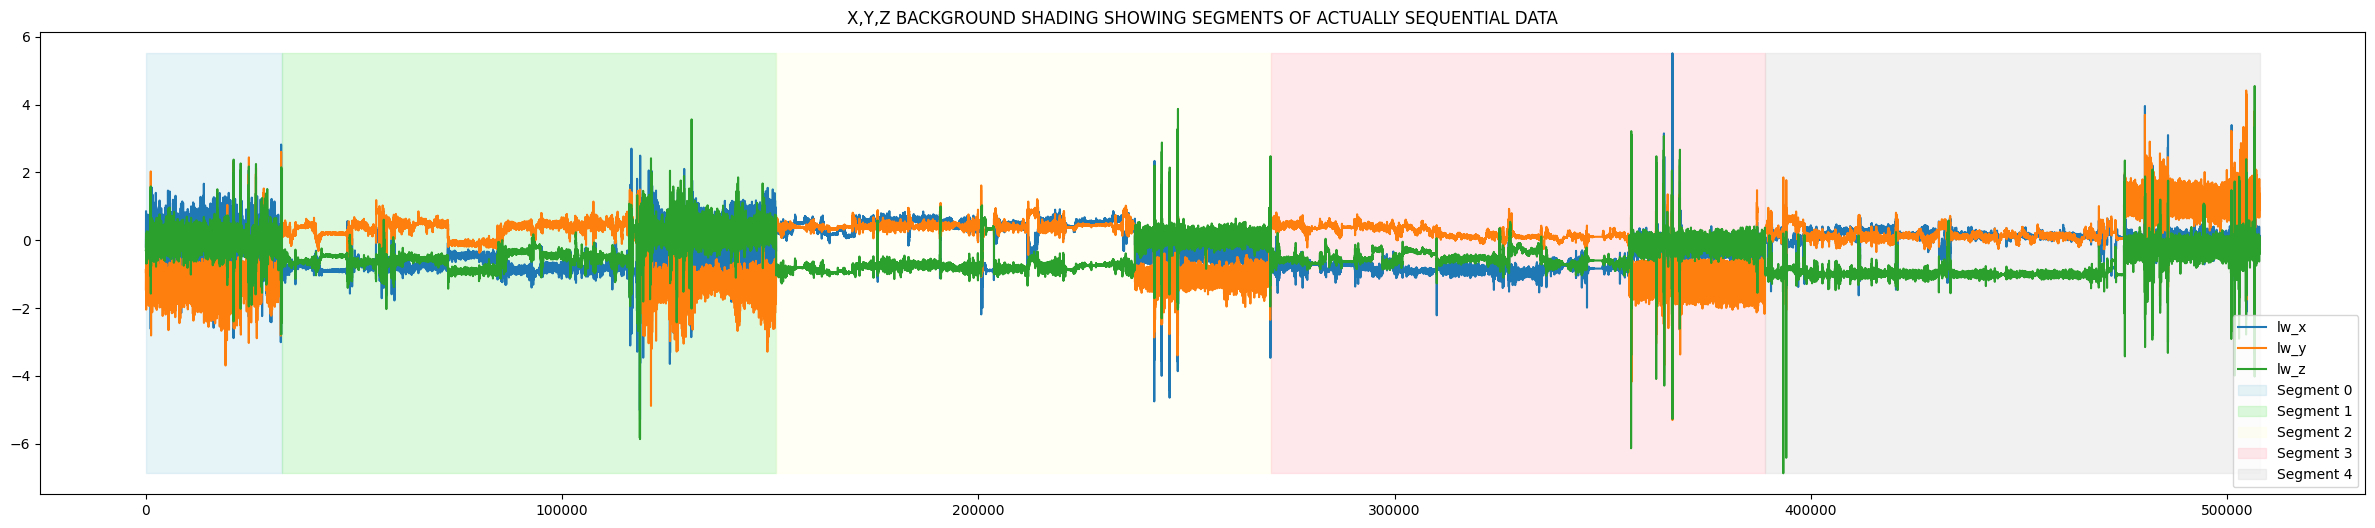

In [6]:
# Create a list of colors for the segments
# This is just an example palette; you can choose your own colors
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']

# Create the initial plot
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['lw_x'], label='lw_x')
plt.plot(df.index, df['lw_y'], label='lw_y')
plt.plot(df.index, df['lw_z'], label='lw_z')

# Find the index ranges for each segment and assign a color
unique_segments = df['segment'].unique()
for i, segment in enumerate(unique_segments):
    segment_indices = df[df['segment'] == segment].index
    if len(segment_indices) > 0:
        color = colors[i % len(colors)]  # Cycle through colors
        plt.fill_betweenx(y=[df[['lw_x', 'lw_y', 'lw_z']].min().min(), df[['lw_x', 'lw_y', 'lw_z']].max().max()],
                          x1=segment_indices[0], x2=segment_indices[-1],
                          color=color, alpha=0.3, label=f'Segment {segment}')

plt.title("X,Y,Z BACKGROUND SHADING SHOWING SEGMENTS OF ACTUALLY SEQUENTIAL DATA")
plt.legend()
plt.show()

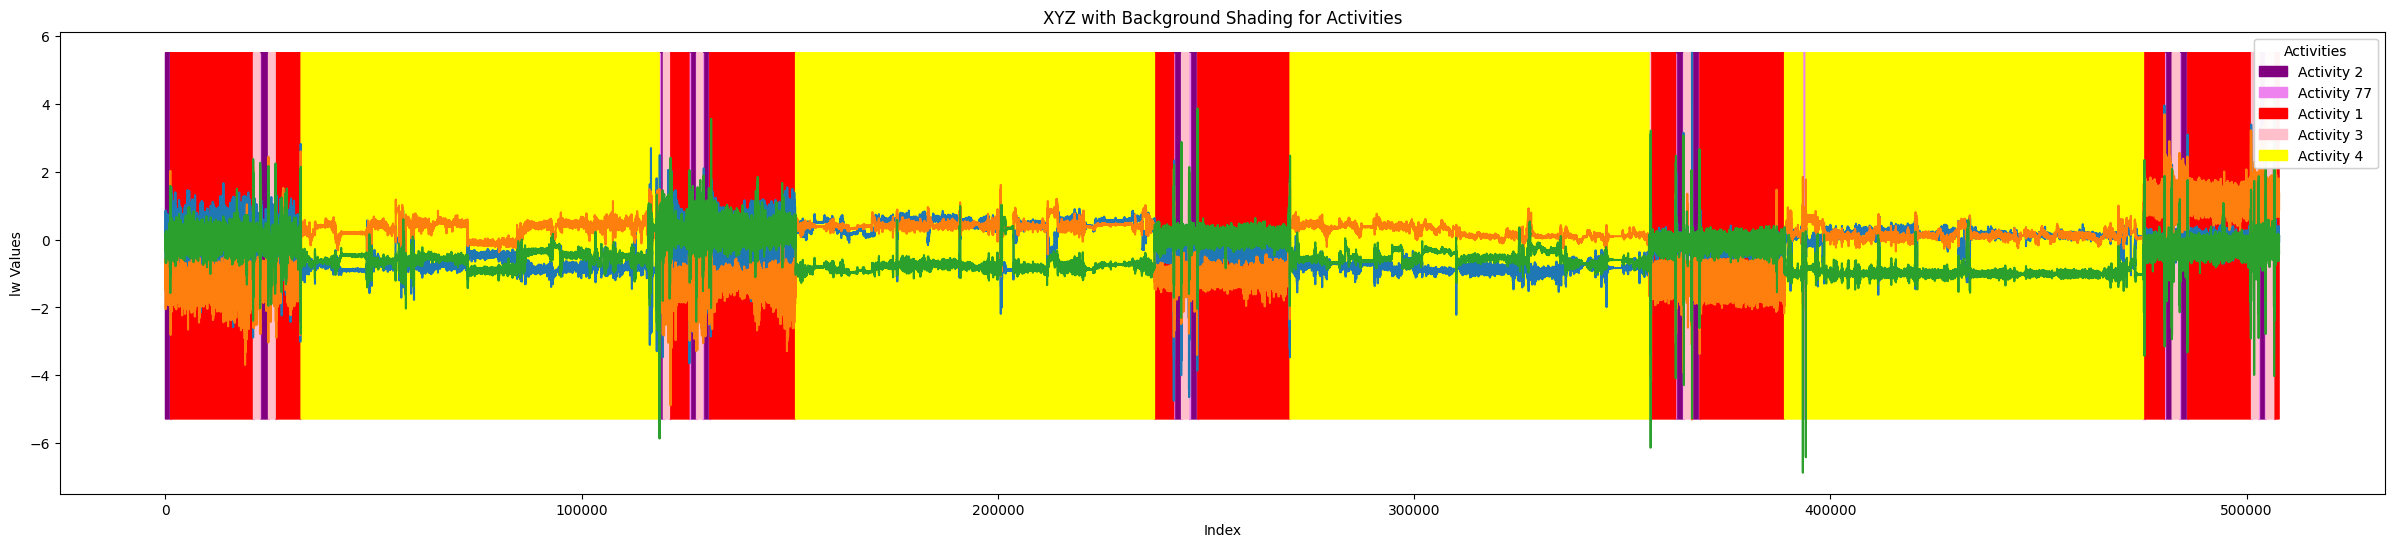

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


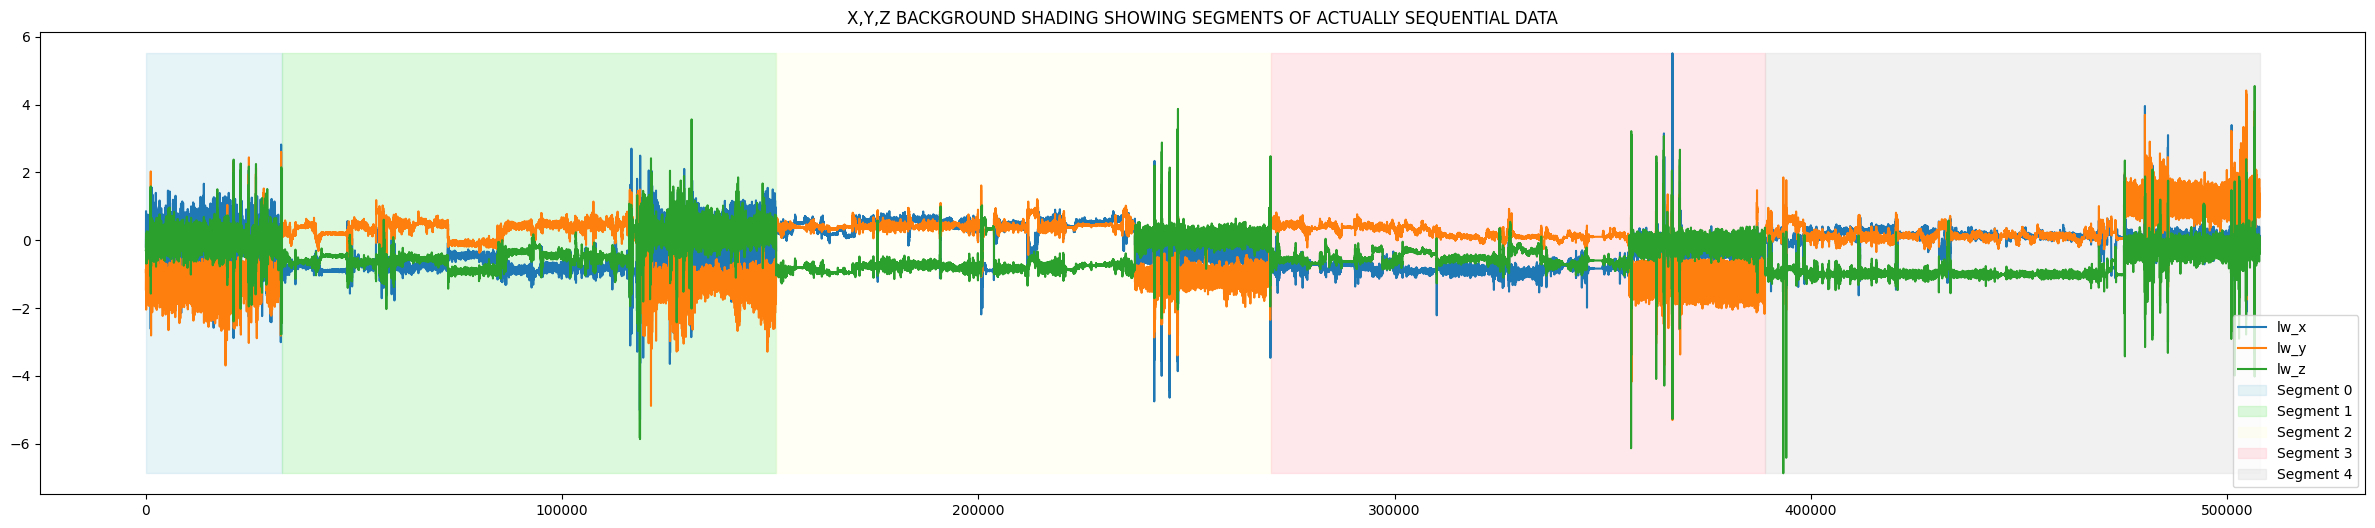

In [7]:
import matplotlib.patches as mpatches


fig, ax = plt.subplots(figsize=(30, 6))

# Plot continuous data
ax.plot(df.index, df['lw_x'], label='lw_x')
ax.plot(df.index, df['lw_y'], label='lw_y')
ax.plot(df.index, df['lw_z'], label='lw_z')
ax.set_ylabel('lw Values')
ax.legend(loc='upper left')

# Add background shading for different activities
activities = df['activity'].unique()
colors = ['purple', 'violet', 'red',
          'pink', 'yellow']  # Customize as needed
for activity, color in zip(activities, colors):
    ax.fill_between(df.index, df['lw_x'].min(), df['lw_x'].max(),
                    where=(df['activity'] == activity), color=color, alpha=1)

# Create custom legend for activities
activity_patches = [mpatches.Patch(
    color=color, label=f'Activity {activity}') for activity, color in zip(activities, colors)]
activity_legend = plt.legend(
    handles=activity_patches, loc='upper right', title='Activities')

# Add the legend back to the plot to keep both legends
ax.add_artist(activity_legend)
plt.title("XYZ with Background Shading for Activities")
plt.xlabel('Index')
plt.show()


colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['lw_x'], label='lw_x')
plt.plot(df.index, df['lw_y'], label='lw_y')
plt.plot(df.index, df['lw_z'], label='lw_z')

unique_segments = df['segment'].unique()
for i, segment in enumerate(unique_segments):
    segment_indices = df[df['segment'] == segment].index
    if len(segment_indices) > 0:
        color = colors[i % len(colors)]  # Cycle through colors
        plt.fill_betweenx(y=[df[['lw_x', 'lw_y', 'lw_z']].min().min(), df[['lw_x', 'lw_y', 'lw_z']].max().max()],
                          x1=segment_indices[0], x2=segment_indices[-1],
                          color=color, alpha=0.3, label=f'Segment {segment}')

plt.title("X,Y,Z BACKGROUND SHADING SHOWING SEGMENTS OF ACTUALLY SEQUENTIAL DATA")
plt.legend()
plt.show()

# activities:
# 2=descending stairs
# 77=clapping;
# 1=walking;
# 3=ascending stairs
# 4=driving

# DRIVING = YELLOW
# WALKING = RED

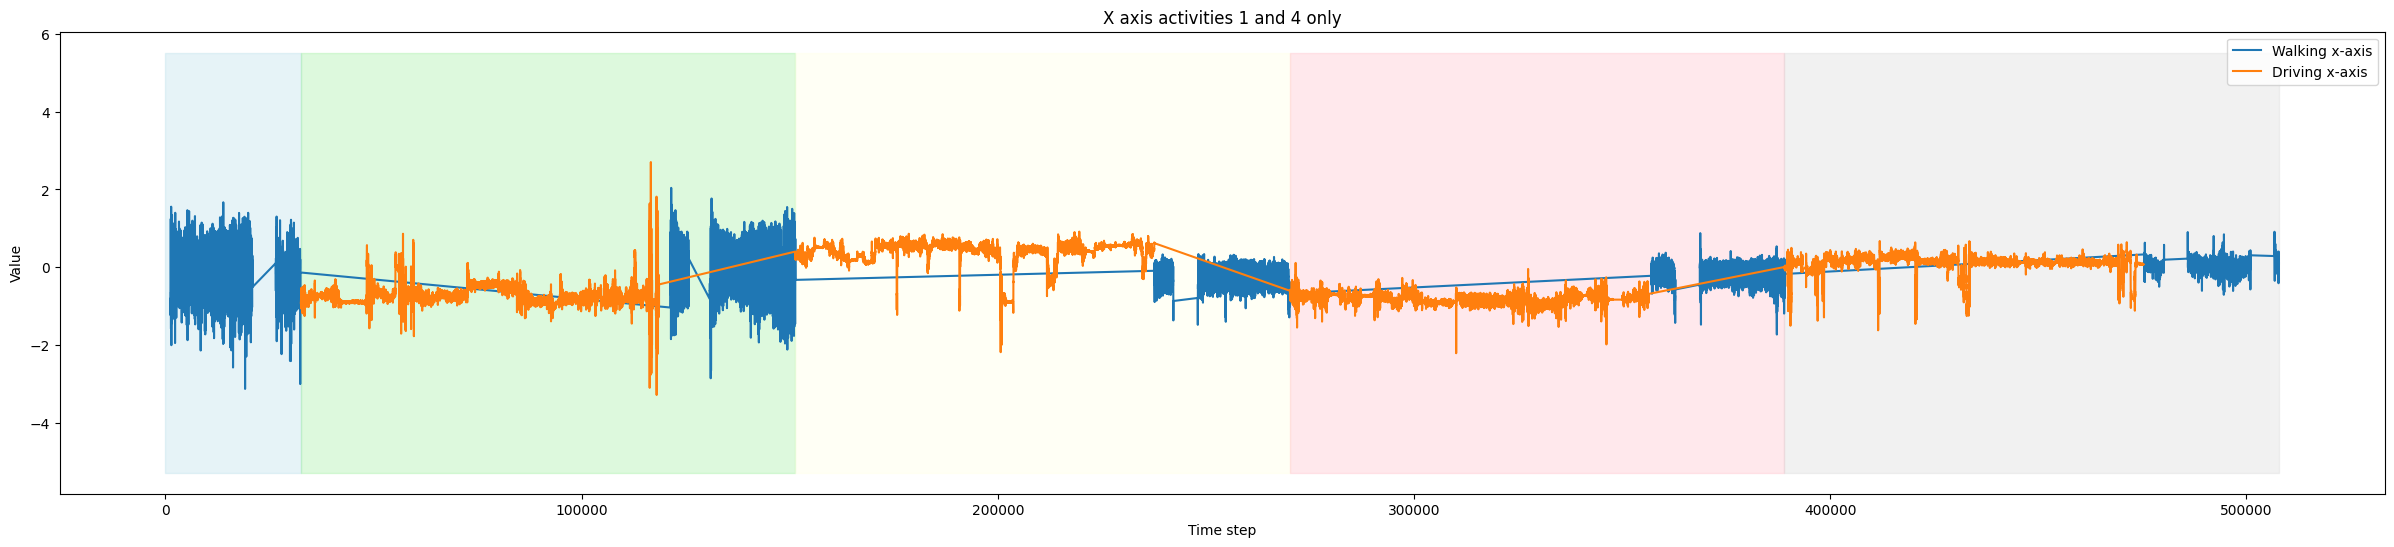

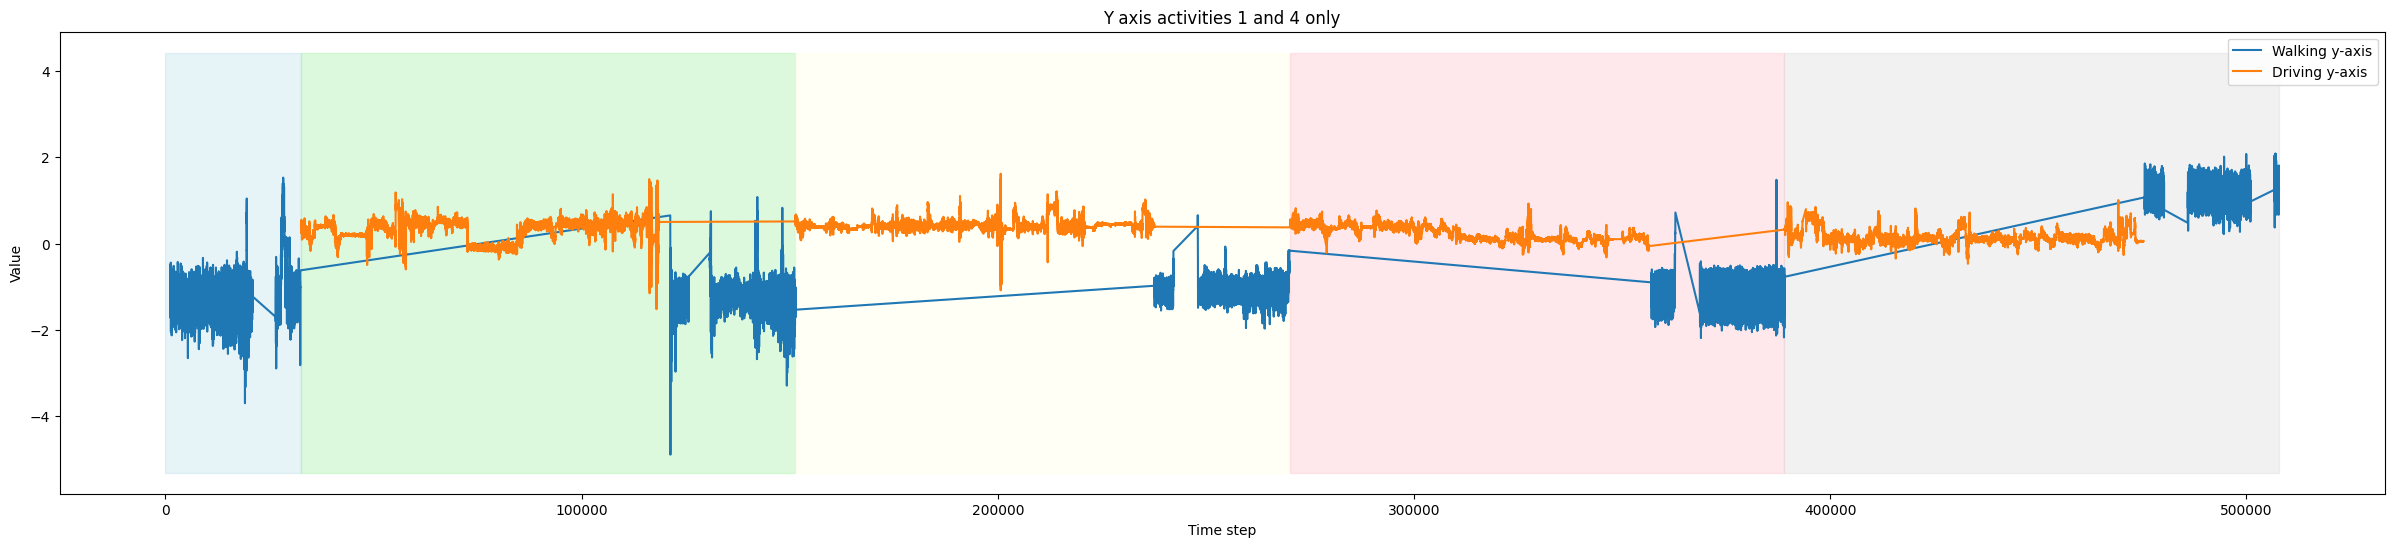

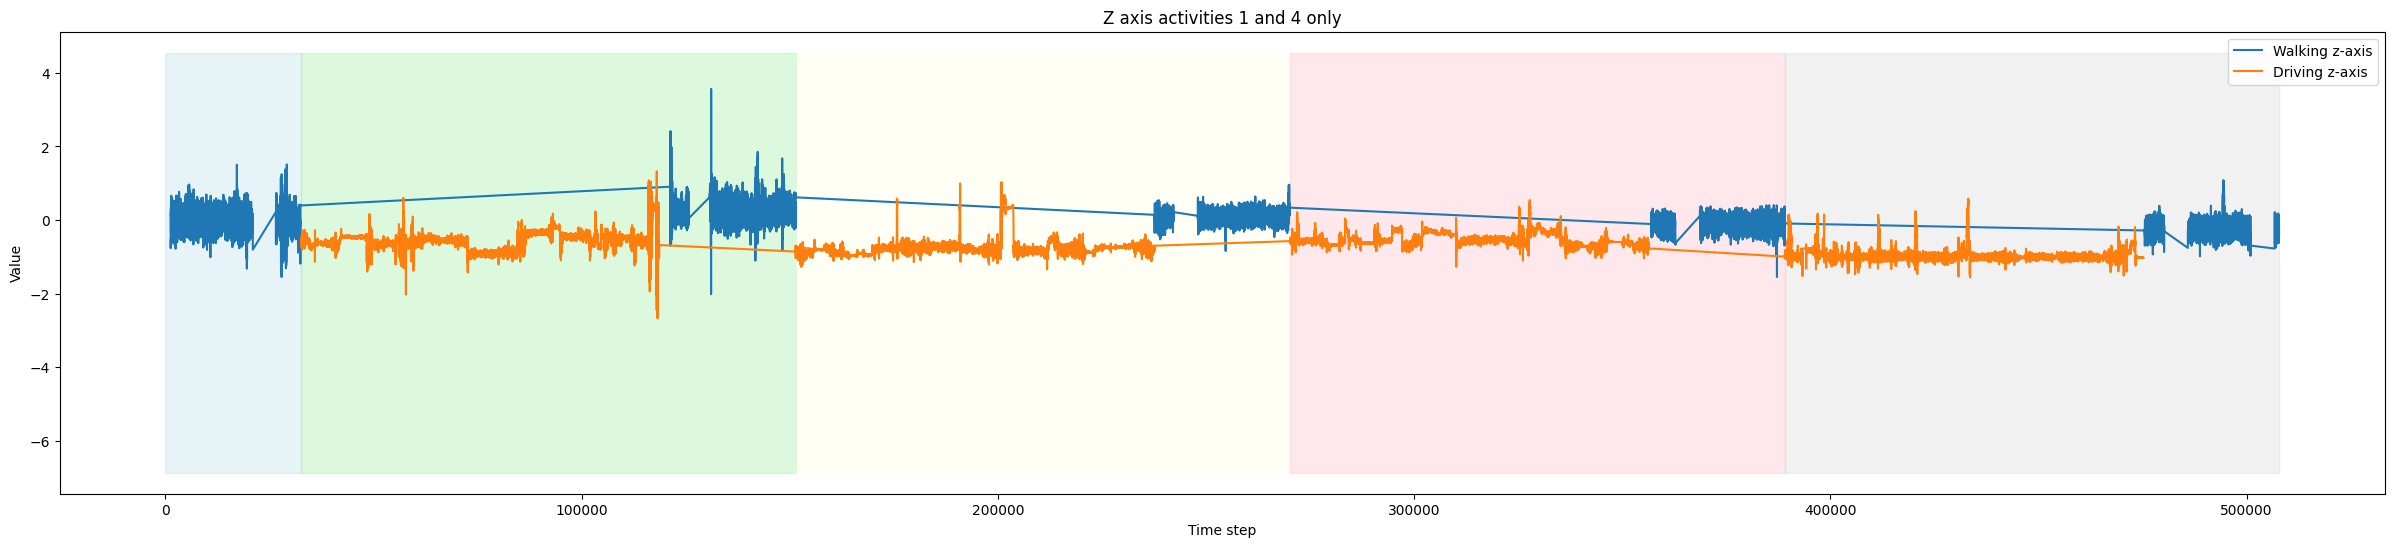

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


# Create a list of colors for the segments
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']

# Function to plot with segment shading


def plot_with_segments(axis, activity_1, activity_2, label_1, label_2):
    plt.figure(figsize=(30, 6))

    # Plot the data
    plt.plot(df.loc[df['activity'] == activity_1, axis], label=label_1)
    plt.plot(df.loc[df['activity'] == activity_2, axis], label=label_2)

    # Add shaded regions for segments
    unique_segments = df['segment'].unique()
    for i, segment in enumerate(unique_segments):
        segment_indices = df[df['segment'] == segment].index
        if len(segment_indices) > 0:
            color = colors[i % len(colors)]  # Cycle through colors
            plt.fill_betweenx(y=[df[axis].min(), df[axis].max()],
                              x1=segment_indices[0], x2=segment_indices[-1],
                              color=color, alpha=0.3)

    plt.title(f'{axis[-1].upper()} axis activities 1 and 4 only')
    plt.legend(loc="upper right")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.show()


# Plot for each axis
plot_with_segments('lw_x', 1, 4, "Walking x-axis", "Driving x-axis")
plot_with_segments('lw_y', 1, 4, "Walking y-axis", "Driving y-axis")
plot_with_segments('lw_z', 1, 4, "Walking z-axis", "Driving z-axis")

In [9]:
# Filtering the DataFrame for activities 1 and 4
# filtered_df = df[df['activity'].isin([1, 4])]

# Selecting only the columns 'lw_x', 'lw_y', 'lw_z'
selected_columns_df = df[['lw_x', 'lw_y', 'lw_z']]

# Grouping by 'activity' and getting summary statistics for the selected columns
summary_by_selected_activity = selected_columns_df.groupby(
    df['activity']).describe()

# This will print the summary statistics
print(summary_by_selected_activity)

              lw_x                                                         \
             count      mean       std    min    25%    50%    75%    max   
activity                                                                    
1         124398.0 -0.097929  0.362294 -3.133 -0.266 -0.055  0.090  2.039   
2          17681.0 -0.125671  0.389747 -2.734 -0.320 -0.074  0.098  2.203   
3          14747.0 -0.110652  0.447066 -2.469 -0.246 -0.031  0.113  2.059   
4         343868.0 -0.261535  0.565142 -3.289 -0.797 -0.441  0.234  2.703   
77          7133.0 -0.187210  0.832005 -5.289 -0.707 -0.145  0.363  5.516   

              lw_y            ...                    lw_z                      \
             count      mean  ...    75%    max     count      mean       std   
activity                      ...                                               
1         124398.0 -0.775183  ... -0.711  2.086  124398.0  0.017579  0.273413   
2          17681.0 -0.431504  ...  0.387  3.344   17681.0 -

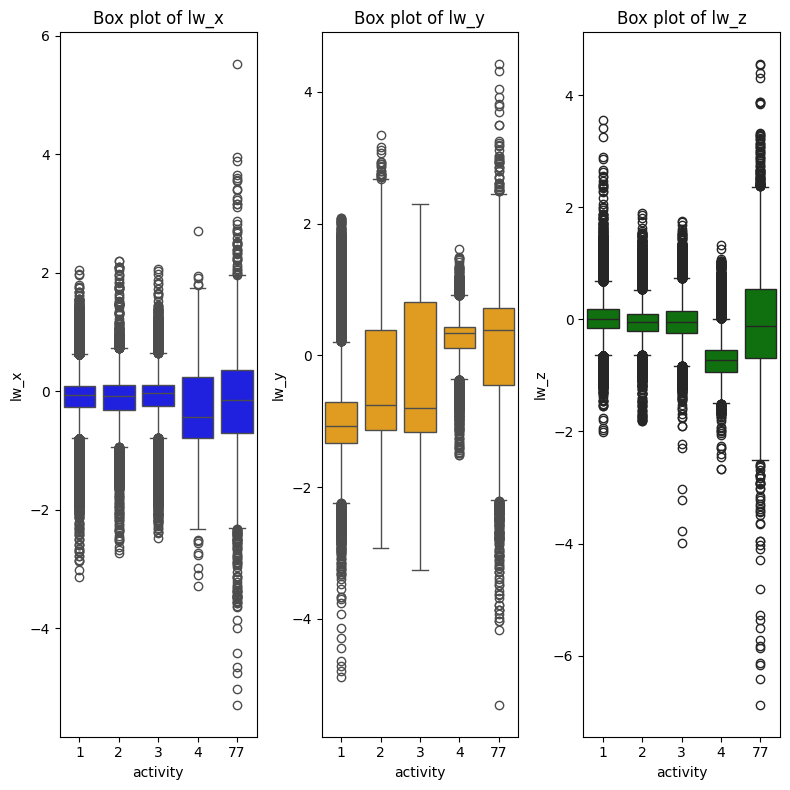

In [10]:

plt.figure(figsize=(8, 8))

# Colors for each plot
colors = {'lw_x': 'blue', 'lw_y': 'orange', 'lw_z': 'green'}

# Creating a box plot for each of the columns with specified colors
for i, column in enumerate(['lw_x', 'lw_y', 'lw_z'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='activity', y=column, data=df, color=colors[column])
    plt.title(f'Box plot of {column}')

plt.tight_layout()
plt.show()

# Training and Predicting


- **Split the DataFrame by Segment:** We'll split your DataFrame into smaller DataFrames based on the 'segment' column.
- **Create Windows:** For each segmented DataFrame, we'll create windows of length 5.


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def scale_columns(df, columns):
    """
    Scales specified columns in the dataframe using StandardScaler.

    :param df: Pandas DataFrame.
    :param columns: List of column names to scale.
    :return: DataFrame with scaled columns.
    """
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return scaler, df


def create_windows(df, window_size=3, skip=1):
    """
    Creates windows of data for each segment.

    :param df: DataFrame with the columns 'lw_x', 'lw_y', 'lw_z', 'activity', 'segment'.
    :param window_size: Size of each window.
    :param skip: Number of rows to skip for the next window.
    :return: Tuple of numpy arrays (X, y).
    """
    X, y = [], []
    unique_segments = np.unique(df['segment'])

    # Convert required columns to NumPy arrays once, outside the loop
    lw_cols = df[['lw_x', 'lw_y', 'lw_z']].to_numpy()
    activities = df['activity'].to_numpy()

    for segment in unique_segments:
        segment_indices = np.flatnonzero(df['segment'].to_numpy() == segment)
        max_index = segment_indices[-1]

        # Use array slicing instead of DataFrame indexing in the loop
        for start in segment_indices:
            end = start + window_size
            if end <= max_index + 1:
                X.append(lw_cols[start:end])
                y.append(activities[end - 1])
                start += skip

    return np.array(X), np.array(y)


# Sample DataFrame creation for demonstration
data = {'lw_x': np.random.rand(100), 'lw_y': np.random.rand(100), 'lw_z': np.random.rand(100),
        'activity': np.random.randint(0, 2, 100), 'segment': np.random.randint(1, 5, 100)}
df_copy = df.copy()

# Replace specific activity value
df_copy['activity'].replace({77: 0}, inplace=True)

# Normalize specific columns
columns_to_normalize = ['lw_x', 'lw_y', 'lw_z']
scaler, df_copy = scale_columns(df_copy, columns_to_normalize)

# Creating windows with optimized function
window_size = 5
X, y = create_windows(df_copy, window_size)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Splitting the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Determine the number of unique classes
num_classes = df['activity'].nunique()


# Building the LSTM model for multi-class classification
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 3)))
model.add(LSTM(50))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Configure Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Training the model with validation data and Early Stopping
model.fit(X_train, y_train, epochs=100, validation_data=(
    X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
 1311/11109 [==>...........................] - ETA: 1:08 - loss: 0.3247 - accuracy: 0.9110

KeyboardInterrupt: 

In [ ]:
!mkdir files

In [ ]:
# with class weight

In [ ]:
import pickle
filename = 'model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
import pickle
filename = 'files/scaler.pkl'
with open(filename, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:

# TODO

# try diff window sizes - document
# custome accuracy for just walking/driving
# class imbalance thing

In [16]:
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Splitting the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Determine the number of unique classes
num_classes = df['activity'].nunique()


# Load the model from the pickle file
filename = 'model.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

# Ensure X_test and y_test are defined and preprocessed as they were for training
predictions = model.predict(X_test)

# If your model outputs probabilities (common in classification), you might need to convert these to class labels
# Adjust if your model's output differs
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Additionally, print a classification report for more insights
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))
print(classification_report(y_test, predicted_labels))

2381/2381 [==============================] - 8s 3ms/step
Confusion Matrix:
[[  667   120    67    34   144]
 [   77 17819   300   332    95]
 [   41   936  1526   123    46]
 [   25  1106   126   905    43]
 [   75    76    33    18 51438]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1032
           1       0.89      0.96      0.92     18623
           2       0.74      0.57      0.65      2672
           3       0.64      0.41      0.50      2205
           4       0.99      1.00      0.99     51640

    accuracy                           0.95     76172
   macro avg       0.80      0.72      0.75     76172
weighted avg       0.95      0.95      0.95     76172

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1032
           1       0.89      0.96      0.92     18623
           2       0.74      0.57      0.65      2672
           3       0.64      

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


# Assuming X, y, and df are defined earlier in your code
# and 'activity' column in df corresponds to your labels

# Splitting the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Determine the number of unique classes
num_classes = df['activity'].nunique()

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Building the LSTM model for multi-class classification
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 3)))  # Ensure window_size is defined
model.add(LSTM(50))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configure Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Training the model with validation data, Early Stopping, and class weights
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
          callbacks=[early_stopping], class_weight=class_weight_dict)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
11109/11109 [==============================] - 137s 8ms/step - loss: 0.9269 - accuracy: 0.8151 - val_loss: 0.5232 - val_accuracy: 0.7864
Epoch 2/10
11109/11109 [==============================] - 78s 7ms/step - loss: 0.8292 - accuracy: 0.8268 - val_loss: 0.4059 - val_accuracy: 0.8360
Epoch 3/10
11109/11109 [==============================] - 83s 8ms/step - loss: 0.7973 - accuracy: 0.8347 - val_loss: 0.3977 - val_accuracy: 0.8525
Epoch 4/10
11109/11109 [==============================] - 83s 7ms/step - loss: 0.7740 - accuracy: 0.8397 - val_loss: 0.3739 - val_accuracy: 0.8611
Epoch 5/10
11109/11109 [==============================] - 81s 7ms/step - loss: 0.7554 - accuracy: 0.8430 - val_loss: 0.4439 - val_accuracy: 0.8264
Epoch 6/10
11109/11109 [==============================] - 76s 7ms/step - loss: 0.7353 - accuracy: 0.8456 - val_loss: 0.3948 - val_accuracy: 0.8481
Epoch 7/10
11109/11109 [==============================] - 80s 7ms/step - loss: 0.7138 - accuracy: 0.8498 - val_loss: 

In [21]:

# Ensure X_test and y_test are defined and preprocessed as they were for training
predictions = model.predict(X_test)

# If your model outputs probabilities (common in classification), you might need to convert these to class labels
# Adjust if your model's output differs
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Additionally, print a classification report for more insights
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))
print(classification_report(y_test, predicted_labels))

2381/2381 [==============================] - 8s 3ms/step
Confusion Matrix:
[[  851    24    66    55    36]
 [  669 13157  2913  1855    29]
 [  223   522  1716   197    14]
 [  163   709   395   925    13]
 [ 2144    19   260   481 48736]]

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.82      0.33      1032
           1       0.91      0.71      0.80     18623
           2       0.32      0.64      0.43      2672
           3       0.26      0.42      0.32      2205
           4       1.00      0.94      0.97     51640

    accuracy                           0.86     76172
   macro avg       0.54      0.71      0.57     76172
weighted avg       0.92      0.86      0.88     76172

              precision    recall  f1-score   support

           0       0.21      0.82      0.33      1032
           1       0.91      0.71      0.80     18623
           2       0.32      0.64      0.43      2672
           3       0.26      